<a href="https://colab.research.google.com/github/ArthurChan-1111/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas_ta
!pip install numpy==1.23.5
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=e268c987649ceac444d982e59ce6f1c7271afe43a7eb61652e5eaffdf34d2ccb
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C


In [1]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

import pandas as pd
import pandas_ta as ta
import csv
import numpy as np

df_bitcoin_by_day = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')


Cloning into 'Bitcoin_prediction'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 58 (delta 14), reused 9 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 3.80 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Bitcoin_prediction


In [2]:
df_bitcoin_by_day.describe().T

,count,unique,top,freq
Date,4112,4112,01/17/2014,1
Price,4112,3974,238.9,4
Open,4112,3967,238.9,4
High,4112,3964,389.3,3
Low,4112,3966,585.4,4
Vol. ('000),4112,3788,1.05M,6
Change %\r,4112,1338,-0.12%\r,16


In [ ]:
def calculate_indicators(df):
    # Calculate RSI
    def rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    # Calculate CCI
    def cci(series, period=14):
        typical_price = (series['High'] + series['Low'] + series['Close']) / 3
        ma = typical_price.rolling(window=period).mean()
        mad = (typical_price - ma).abs().rolling(window=period).mean()
        return (typical_price - ma) / (0.015 * mad)

    # Calculate Bollinger Bands
    def bollinger_bands(series, window=20, num_std_dev=2):
        sma = series['Close'].rolling(window=window).mean()
        rstd = series['Close'].rolling(window=window).std()
        upper_band = sma + (rstd * num_std_dev)
        lower_band = sma - (rstd * num_std_dev)
        return upper_band, lower_band

    # Calculating indicators
    df['RSI7'] = rsi(df['Close'], period=7)
    df['RSI14'] = rsi(df['Close'], period=14)
    df['CCI7'] = cci(df, period=7)
    df['CCI14'] = cci(df, period=14)
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Bollinger_Upper'], df['Bollinger_Lower'] = bollinger_bands(df)

    #Cup and handle signal
    df['Cup_Handle_Signal'] = 0  # Initialize signal column with 0

    for i in range(20, len(df) - 10):  # Start from index 20 to ensure enough data for the pattern
        # Define the cup pattern
        cup_start = i - 20  # Look back 20 periods for the start of the cup
        cup_end = i  # Current index is the end of the cup
        handle_start = i + 1  # Start of the handle
        handle_end = i + 10  # End of the handle (10 periods forward)

        # Check for a rounded cup shape
        cup_prices = df['Close'].iloc[cup_start:cup_end + 1]
        cup_bottom = cup_prices.min()
        cup_top = max(cup_prices.iloc[0], cup_prices.iloc[-1])  # Top of the cup (start and end prices)
        cup_depth = cup_top - cup_bottom

        # Ensure the cup is rounded (symmetry check)
        left_side = cup_prices.iloc[:len(cup_prices) // 2]
        right_side = cup_prices.iloc[len(cup_prices) // 2:]
        if not (left_side.mean() > cup_bottom and right_side.mean() > cup_bottom):
            continue  # Skip if the cup is not rounded

        # Ensure the current price is near the top of the cup (end of the cup)
        if df['Close'].iloc[i] < cup_top * 0.95:  # Allow a 5% tolerance
            continue  # Skip if the price is not near the top of the cup

        # Check for the handle pattern
        handle_prices = df['Close'].iloc[handle_start:handle_end + 1]
        handle_slope = (handle_prices.iloc[-1] - handle_prices.iloc[0]) / len(handle_prices)

        # Ensure the handle has a slight downward slope
        if handle_slope >= 0:
            continue  # Skip if the handle does not slope downward

        # Ensure the handle does not drop below 50% of the cup depth
        if handle_prices.min() < cup_bottom + 0.5 * cup_depth:
            continue  # Skip if the handle drops too far

        # Ensure the handle ends with a breakout above the cup top
        if handle_prices.iloc[-1] <= cup_top:
            continue  # Skip if the handle does not end with a breakout

        # Record the Cup and Handle signal
        df.loc[handle_end, 'Cup_Handle_Signal'] = 1  # Mark the end of the handle as the signal point

    #/Cup and handle signal

    # Set Binary Signal
    df['Signal_Up'] = 0

    # Use .loc for assignment to avoid warnings
    df.loc[1:, 'Signal_Up'] = np.where(df['Close'].iloc[1:].values > df['Close'].iloc[:-1].values, 1, 0)


    # Add a column to indicate if the price rose by 5% or more compared to the previous day
    df_bitcoin_by_day['Signal_5Percent_Up'] = 0  # Initialize with 0

    # Use .loc for assignment to avoid warnings
    df_bitcoin_by_day.loc[1:, 'Signal_5Percent_Up'] = np.where(
        (df_bitcoin_by_day['Close'].iloc[1:].values >= df_bitcoin_by_day['Close'].iloc[:-1].values * 1.05),
        1,
        0
    )
    return df

calculate_indicators(df_bitcoin_by_day)

df_bitcoin_by_day.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
2633,2025-03-18,84010.02,84021.74,83017.88,83018.33,1110.53302,2025-03-18 23:59:59.999,9.266588e+07,179190,436.70291,...,68.363371,41.512263,3.070044,-29.091901,92459.5592,92228.296511,78262.968489,0,0,0
2634,2025-03-19,82715.03,83280.00,82603.20,83010.87,1360.52066,2025-03-19 23:59:59.999,1.129231e+08,209016,829.38438,...,46.272092,33.562588,-25.112016,-27.920901,92093.0662,92100.209554,78046.600446,0,0,0
2635,2025-03-20,86845.93,87453.67,85733.11,85905.91,3146.08729,2025-03-20 23:59:59.999,2.723224e+08,399959,1421.72638,...,61.212357,41.838930,151.593782,67.947207,91736.5196,92177.214055,78294.227945,0,1,0
2636,2025-03-21,84223.38,84748.44,84180.09,84711.21,656.96798,2025-03-21 23:59:59.999,5.548234e+07,117589,341.94482,...,69.261525,45.401429,29.070907,27.628368,91336.2850,92181.597884,78303.586116,0,0,0
2637,2025-03-22,84088.79,84338.98,83989.58,84037.82,534.27259,2025-03-22 23:59:59.999,4.496609e+07,86830,231.88751,...,48.410583,44.864757,4.511839,21.414159,90968.4502,90226.130479,79235.835521,0,0,0


In [ ]:
df_bitcoin_by_day[df_bitcoin_by_day['Signal_Up']==1]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
5,2018-01-06,16960.39,17143.13,16011.21,17069.79,18571.457508,2018-01-06 23:59:59.999,3.092169e+08,158242,11007.164056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,2025-03-05,87281.98,90933.82,86334.53,90283.57,36649.484150,2025-03-05 23:59:59.999,3.254229e+09,7716640,18359.331920,...,60.149200,44.278219,40.253500,-23.914560,97367.9326,103117.912039,81965.731961,0,1,0
2627,2025-03-12,82932.99,83591.07,82604.95,83488.72,1624.191460,2025-03-12 23:59:59.999,1.349775e+08,311866,977.529250,...,28.378680,49.162174,-32.037434,-39.030067,94897.7358,99531.739980,77298.730020,0,1,1
2628,2025-03-13,83680.12,84000.00,83312.92,83915.10,1854.128840,2025-03-13 23:59:59.999,1.552110e+08,273157,940.659960,...,30.945065,47.090678,-0.568450,-32.759954,94501.9046,97947.414677,77444.565323,0,1,0
2630,2025-03-15,83983.19,84583.04,83964.57,84227.92,782.819720,2025-03-15 23:59:59.999,6.596448e+07,131694,425.748270,...,43.619037,49.595132,40.758207,-29.557826,93644.6198,95043.867155,77656.577845,0,1,0


In [ ]:
df_bitcoin_by_day[df_bitcoin_by_day['Signal_5Percent_Up']==1]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
19,2018-01-20,11474.98,13099.00,11412.45,12799.94,28768.857827,2018-01-20 23:59:59.999,3.585611e+08,251647,14389.196005,...,36.928057,30.954953,28.910079,NaN,NaN,17560.179217,10215.159783,0,1,1
23,2018-01-24,10799.14,11570.48,10500.00,11349.99,27158.587762,2018-01-24 23:59:59.999,2.994706e+08,293429,13087.393088,...,54.018137,33.320079,-19.936438,NaN,NaN,17383.720292,9032.124708,0,1,1
36,2018-02-06,6939.63,7878.00,6000.01,7652.14,100201.500307,2018-02-06 23:59:59.999,6.843643e+08,785996,49565.020794,...,22.835390,30.340584,-69.165579,-142.530181,NaN,13417.628766,7298.310234,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,2024-11-06,69372.01,76400.00,69298.00,75571.99,104126.994787,2024-11-06 23:59:59.999,7.702283e+09,8434184,53243.884427,...,63.208343,70.537266,165.962242,188.375440,65715.1014,73606.891524,64702.842476,0,1,1
2506,2024-11-11,80370.01,89530.54,80216.01,88647.99,82323.665776,2024-11-11 23:59:59.999,6.944269e+09,9348890,42837.295314,...,100.000000,82.829760,133.646642,220.988960,67379.6290,83108.094125,60943.803875,0,1,1
2577,2025-01-21,102260.00,107240.81,100119.04,106143.82,45941.020020,2025-01-21 23:59:59.999,4.768512e+09,6842980,23227.027410,...,74.440516,66.180939,48.817859,136.925247,98354.8208,106095.737591,90920.631409,0,1,1
2617,2025-03-02,86064.54,95000.00,85050.60,94270.00,54889.090450,2025-03-02 23:59:59.999,4.972550e+09,7403218,29273.810310,...,46.374818,47.460192,41.397778,-17.564925,97805.0498,104169.665347,83781.596653,0,1,1


In [ ]:
df_bitcoin_by_day[df_bitcoin_by_day['Cup_Handle_Signal']==1]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
65,2018-03-07,10716.48,10899.00,9389.31,9910.00,50647.671080,2018-03-07 23:59:59.999,5.148080e+08,396721,24022.451231,...,42.539846,45.205519,-103.106310,-76.266676,10150.9172,11811.024631,9372.965369,1,0,0
212,2018-08-01,7735.67,7750.00,7430.00,7604.58,42582.312932,2018-08-01 23:59:59.999,3.222521e+08,208008,22159.785618,...,25.825897,54.149183,-124.896424,-25.608378,6857.4374,8865.339778,6153.410222,1,0,0
278,2018-10-06,6635.65,6651.00,6566.77,6594.27,10939.505391,2018-10-06 23:59:59.999,7.224794e+07,62065,5212.866094,...,49.663788,43.028669,42.769780,17.679307,6617.7092,6823.042068,6294.049932,1,0,0
316,2018-11-13,6451.68,6498.00,6391.15,6457.66,11790.564933,2018-11-13 23:59:59.999,7.614298e+07,150940,6176.466277,...,37.974089,61.097982,-30.298173,0.413465,6521.8988,6584.558982,6324.086018,1,1,0
422,2019-02-27,3809.31,3838.85,3677.17,3818.07,31500.995466,2019-02-27 23:59:59.999,1.195640e+08,201626,16214.235846,...,39.150464,59.511026,-64.559044,-18.355712,3631.0054,4078.010290,3456.708710,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,2024-11-30,97460.00,97463.95,96092.01,96407.99,14503.833060,2024-11-30 23:59:59.999,1.402673e+09,3354759,7075.915030,...,45.191491,62.059810,46.681482,22.322262,79055.1530,100788.303925,85808.597075,1,0,0
2535,2024-12-10,97276.48,98270.00,94256.54,96593.00,51708.689330,2024-12-10 23:59:59.999,4.988660e+09,11556189,24523.095860,...,52.845779,60.434438,-80.237935,-32.431052,85284.5266,101438.275018,92770.938982,1,0,0
2545,2024-12-20,97461.86,98233.00,92232.54,97805.44,62884.135700,2024-12-20 23:59:59.999,6.022845e+09,7429007,29463.230210,...,36.824833,46.374496,-111.708073,-97.039832,91817.7294,105973.143533,93533.013467,1,1,0
2582,2025-01-26,104746.86,105500.00,102520.44,102620.00,9812.512380,2025-01-26 23:59:59.999,1.024352e+09,1813011,4642.172470,...,54.874497,64.687114,-14.484174,30.845507,98932.7984,108699.861753,90904.074247,1,0,0


In [ ]:
# Filter rows where Cup_Handle_Signal is 1
cup_handle_signal_df = df_bitcoin_by_day[df_bitcoin_by_day['Cup_Handle_Signal'] == 1]

# Calculate probabilities
prob_signal_up = cup_handle_signal_df['Signal_Up'].mean()
prob_signal_5percent_up = cup_handle_signal_df['Signal_5Percent_Up'].mean()

print(f"Probability of Signal_Up when Cup_Handle_Signal is 1: {prob_signal_up:.2%}")
print(f"Probability of Signal_5Percent_Up when Cup_Handle_Signal is 1: {prob_signal_5percent_up:.2%}")

Probability of Signal_Up when Cup_Handle_Signal is 1: 38.75%
Probability of Signal_5Percent_Up when Cup_Handle_Signal is 1: 0.00%


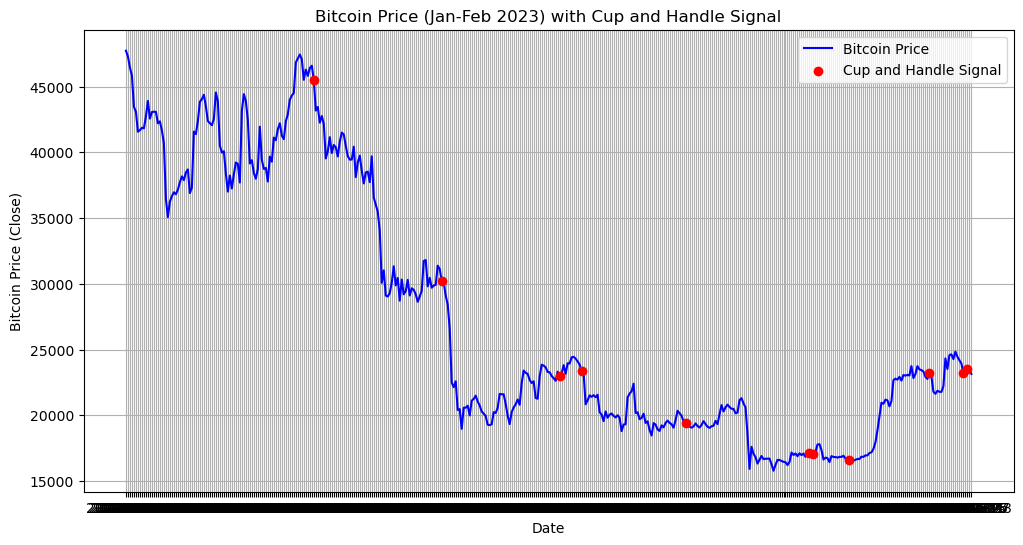

In [ ]:
import matplotlib.pyplot as plt

# Filter data for January and February 2023
filtered_data = df_bitcoin_by_day[
    (df_bitcoin_by_day['Open time'] >= '2022-01-01') &
    (df_bitcoin_by_day['Open time'] <= '2023-02-28')
]

# Plot Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Open time'], filtered_data['Close'], label='Bitcoin Price', color='blue')

# Highlight Cup and Handle signals
cup_handle_data = filtered_data[filtered_data['Cup_Handle_Signal'] == 1]
plt.scatter(cup_handle_data['Open time'], cup_handle_data['Close'], color='red', label='Cup and Handle Signal', zorder=5)

# Add labels and legend
plt.title('Bitcoin Price (Jan-Feb 2023) with Cup and Handle Signal')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (Close)')
plt.legend()
plt.grid(True)
plt.show()